# Banking predictions 

## 0. Dowlnoad and import packages/dataset

**Import packages and dataset**

In [41]:
import numpy as np
import pandas as pd
import math

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import scipy.stats as ss
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, average_precision_score, precision_recall_curve, roc_curve

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier

import optuna
from optuna.samplers import TPESampler

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore")

sns.set()

In [3]:
df = pd.read_csv('bank_full.csv', delimiter=';')


## 1. Exploration des données

### 1.1 Statistiques élémentaires

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
print('Dimension dataframe :', df.shape)

Dimension dataframe : (41188, 21)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  object 
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  object 
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

**Describe des valeurs numériques**

In [7]:
df.describe()

,duration,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,258.285010,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,259.279249,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,0.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,102.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,180.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,319.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,4918.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


**Données manquantes**

In [8]:
df.isnull().values.any()

False

In [9]:
df.isnull().sum() # OK

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

 Notre dataset ne comporte pas de données manquantes

### 1.2 Nettoyage des données

In [10]:
missing_columns = [col for col in df.columns if (df[col] == ' ').any()]
missing_columns

['age', 'marital', 'campaign']

Nous voyons que les colonnes **age**, **marital** et **campaign** possèdent au moins une valeur non renseignée

**Variable age**

Nous voyons que la variable **age** est classée en catégorie object comme dtypes : 

In [11]:
df.age.dtype

dtype('O')

In [12]:
df.age.value_counts().keys()

Index(['31', '32', '33', '36', '35', '34', '30', '37', '29', '39', '38', '41',
       '40', '42', '45', '43', '46', '44', '28', '48', '47', '50', '27', '49',
       '52', '51', '53', '56', '26', '54', '55', '57', '25', '58', '24', '59',
       '60', '23', '22', '21', '61', '20', '62', '66', '64', '63', '71', '70',
       '65', '19', '76', '72', '69', '73', '68', '74', '80', '18', '78', '67',
       '75', '88', '81', '77', '83', '82', '85', '79', '86', '84', '17', ' ',
       '92', '98', '89', '91', '87', '94', '143', '158', '95'],
      dtype='object', name='age')

In [13]:
df.query('age == " "')

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
17352,,services,married,high.school,no,yes,no,cellular,jul,mon,...,8,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
25937,,blue-collar,married,basic.9y,no,no,no,cellular,nov,wed,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8,no
26661,,admin.,single,university.degree,no,yes,no,cellular,nov,thu,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.076,5195.8,no
38155,,admin.,single,university.degree,no,yes,no,cellular,oct,thu,...,3,999,0,nonexistent,-3.4,92.431,-26.9,0.754,5017.5,yes


Nous observons 2 choses : 
- La présence d'age non renseigné ' '
- La présence d'age abérrant (158 et 143)

Ces deux éléments étant des anomalies, nous retirons les lignes concernées de notre dataframe initial. Enfin nous transformons le type de cette variable en *int*.

In [14]:
# drop des lignes où  l'age n'est pas renseigné
df = df.drop(df.query('age == " "').index)

# Changement du type
df['age'] = df['age'].astype('int16')

# Supression des ages trop élevés
df = df.drop(df.query('age > 100').index)

**Variable campaign**

Tout comme la variable **age**,  nous observons également pour la variable **campaign**, censé représenter le nombre de contacts;  des valeurs non renseignées.

In [15]:
df.campaign.value_counts().keys()

Index([ '1',  '2',  '3',    1,    2,  '4',  '5',    3,  '6',  '7',    4,  '8',
          5,  '9', '10',    6, '11', '12',    7, '13', '14',    8, '17', '16',
       '15',    9, '18', '20', '19', '21',   10, '22', '23', '24',   11, '27',
       '29', '26', '28', '25', '30', '31',   12, '35',  ' ', '33', '32',   15,
       '34',   13, '42', '43', '40',   14, '37', '56', '39', '41',   16],
      dtype='object', name='campaign')

In [16]:
df.query('campaign == " "')

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
430,43,self-employed,divorced,university.degree,no,no,no,telephone,may,tue,...,,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
438,47,admin.,divorced,university.degree,no,no,no,telephone,may,tue,...,,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
24342,40,management,married,university.degree,no,yes,yes,cellular,nov,mon,...,,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no
24366,45,services,divorced,high.school,no,yes,yes,cellular,nov,mon,...,,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [17]:
# drop des lignes où  l'age n'est pas renseigné
df = df.drop(df.query('campaign == " "').index)

# Changement du type
df['campaign'] = df['campaign'].astype('int16')

**Variable marital**

In [18]:
df.query('marital == " "')

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
560,41,blue-collar,,basic.4y,no,no,no,telephone,may,tue,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
18872,35,admin.,,university.degree,no,no,no,cellular,aug,mon,...,2,999,0,nonexistent,1.4,93.444,-36.1,4.970,5228.1,no
18877,57,admin.,,high.school,unknown,yes,no,cellular,aug,mon,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.970,5228.1,no
35192,54,entrepreneur,,high.school,no,yes,no,cellular,may,fri,...,1,999,1,failure,-1.8,92.893,-46.2,1.250,5099.1,no
35209,37,admin.,,high.school,no,no,no,cellular,may,fri,...,3,999,0,nonexistent,-1.8,92.893,-46.2,1.250,5099.1,no
37706,66,retired,,basic.6y,no,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,-2.9,92.201,-31.4,0.851,5076.2,yes


In [19]:
# drop des lignes où marital n'est pas renseigné
df = df.drop(df.query('marital == " "').index)

### 1.3 Analyse univariée

**Variables catégoriques**

In [20]:
# Récupération des variables catégoriques mises à jour
var_cat = df.select_dtypes(include=['object']).columns.tolist()

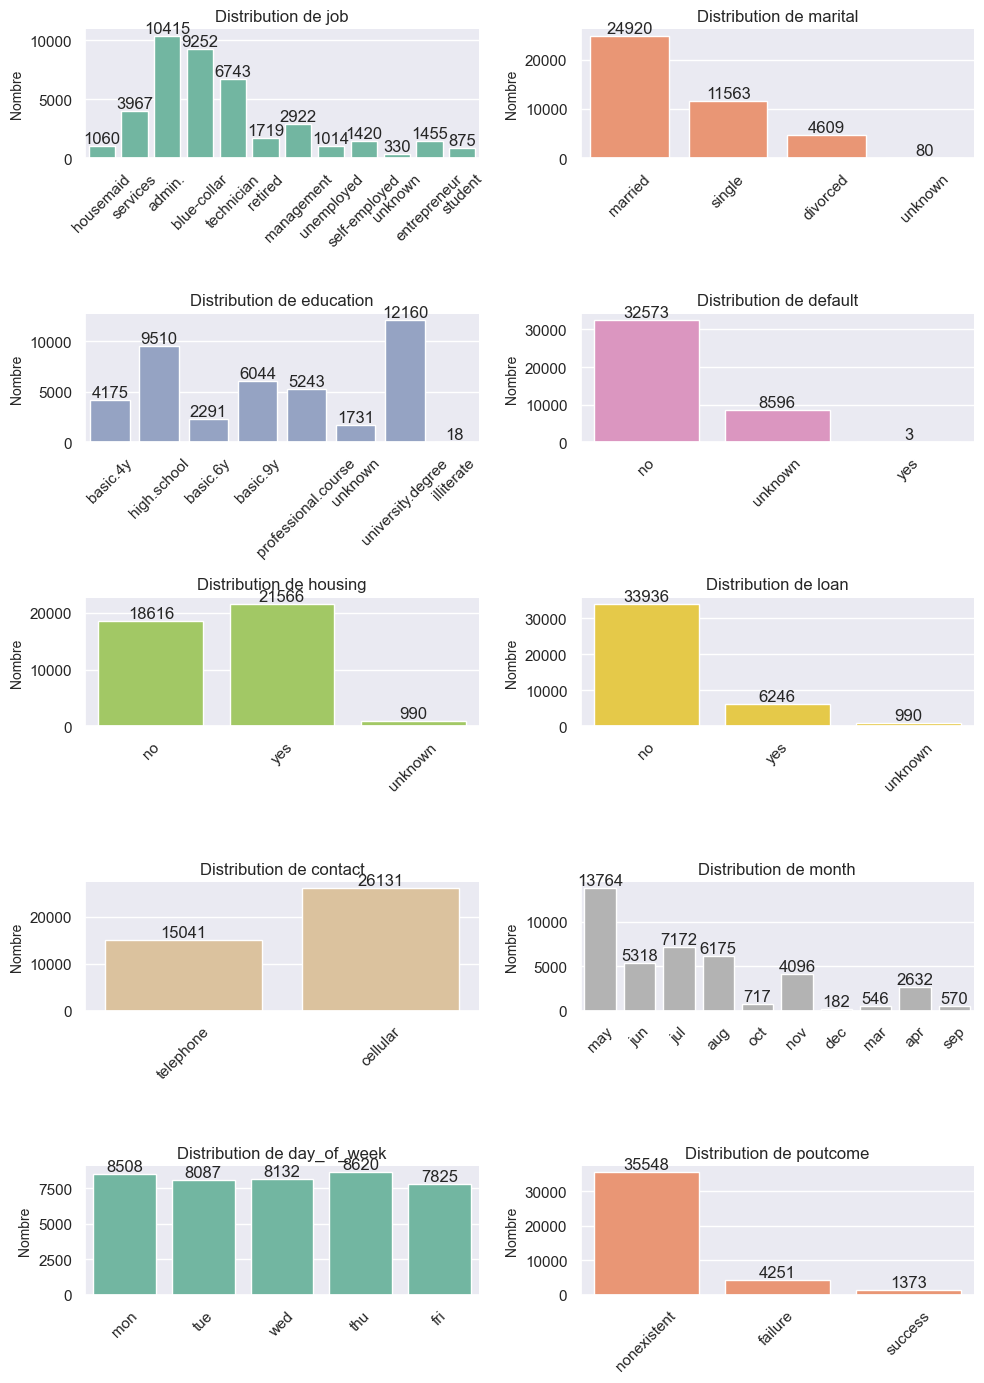

In [21]:
palette = sns.color_palette("Set2", len(var_cat))  # Adjust the palette name as desired

fig, ax = plt.subplots(5, 2, figsize=(10, 14))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

for i, subplot, color in zip(var_cat, ax.flatten(), palette):
    ax = sns.countplot(x=i, data=df, ax=subplot, color=color)  # Use the color palette
    ax.bar_label(ax.containers[0])
    ax.spines[['right', 'top']].set_visible(False)

    subplot.set_title(f'Distribution de {i}', fontsize=12)
    subplot.set_xlabel(None)
    subplot.set_ylabel('Nombre', fontsize=10)
    subplot.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

Bien que certaines modalitées de certaines variables soient peu representées, nous conservons ces dernières. A noter qu'aucune de ces variables catégorielles sont ordinales, nous devrons donc transformer toutes ces variables en les one hot encodant. 

**Variables numériques**

In [22]:
# fonction pour visu histogramme, boxplot et QQplot
def visu_plots(df, variable):
    plt.figure(figsize=(16, 4))
    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(data=df, x=variable, kde=True,)
    plt.title('Histogram')
    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    # Q-Q plot
    plt.subplot(1, 3, 2)
    ss.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')
    plt.show()

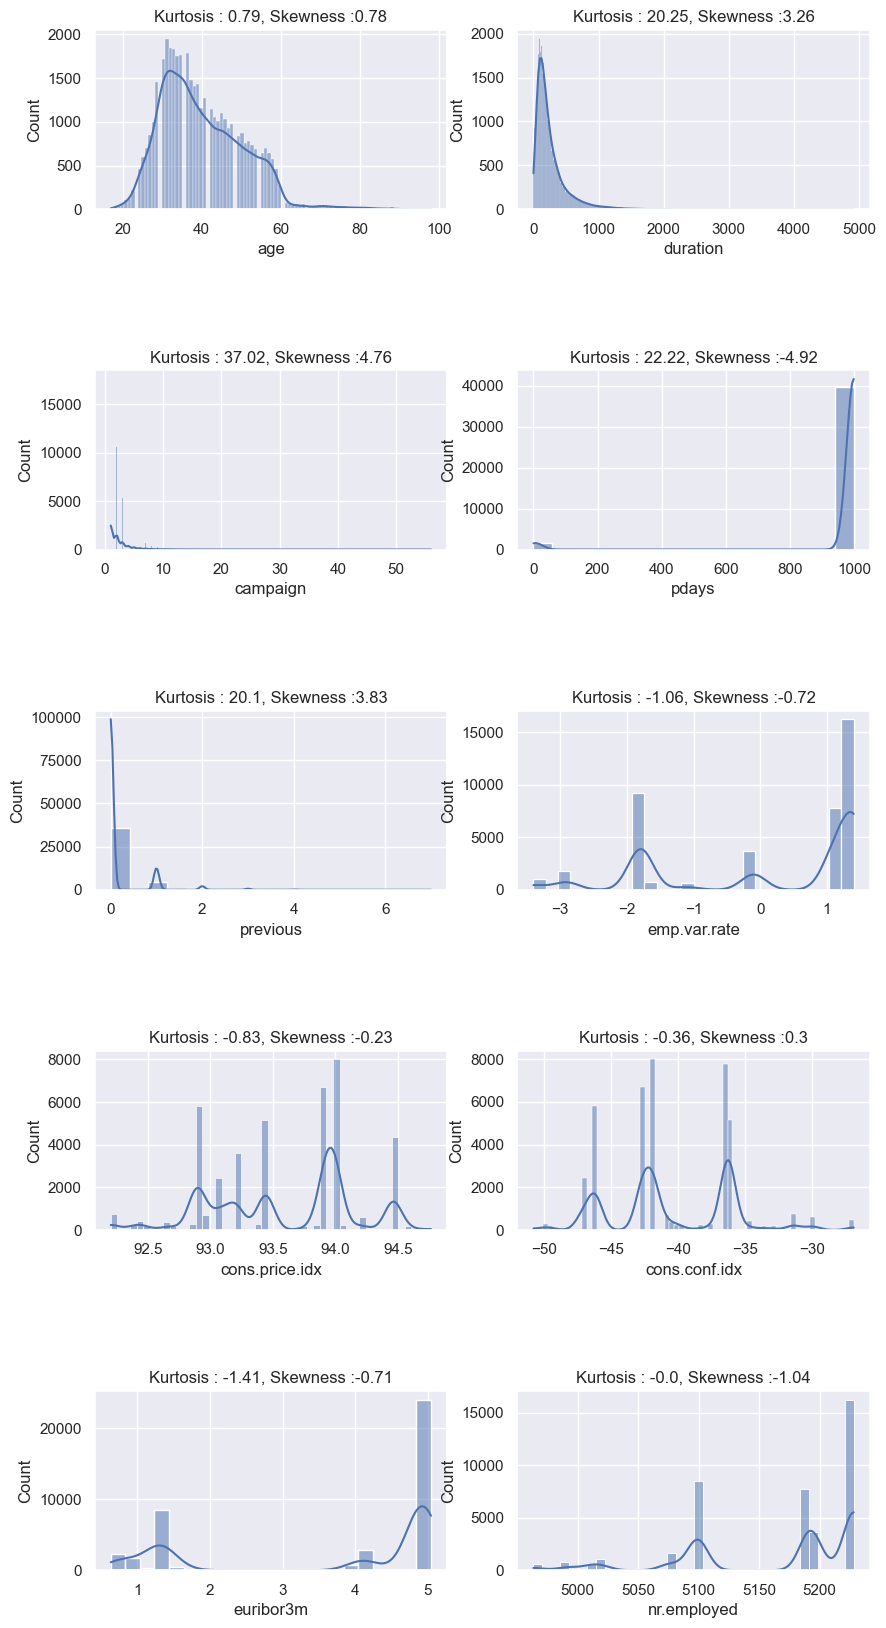

In [23]:
num_rows = 5
num_cols = 2
cols_numeriques = df.select_dtypes(include=['number']).columns.tolist()

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 20))
axes = axes.flatten()

for i, column in enumerate(cols_numeriques):
    sns.histplot(data=df, x=column, kde=True, ax=axes[i])
    kurtosis = np.round(df[column].kurtosis(), 2)
    skewness = np.round(df[column].skew(), 2)
    axes[i].set_title('Kurtosis : ' +str(kurtosis)+ ', Skewness :' + str(skewness))  # Set subplot title to column name

plt.subplots_adjust(hspace=0.9)
plt.show()

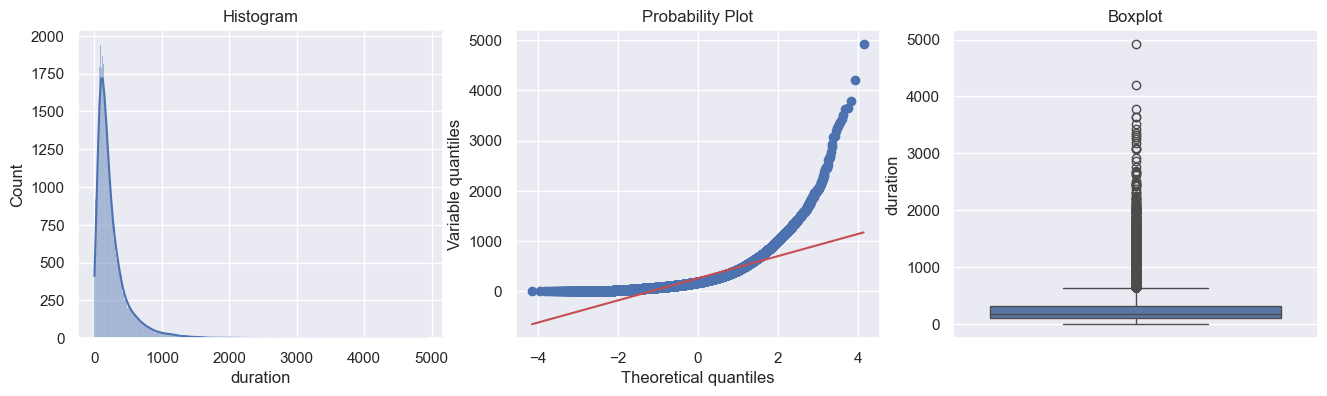

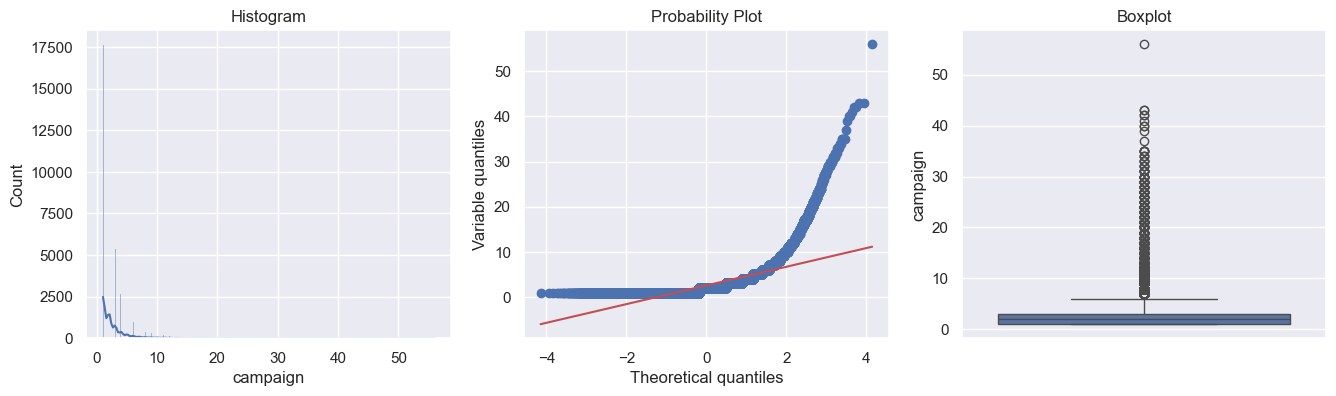

In [24]:
## Affichage en détail de la variable revenuFinal
visu_plots(df, 'duration')
visu_plots(df, 'campaign')

Nous observons pour certaines variables comme **campaign** ou **duration** une forte assymétrie, sans pour autant avoir de valeurs abbérantes. Nous conservons ces parmètres pour notre modélisation.

### 1.4 Analyse bivariée

Notre target variable **y** étant si le client a souscris ou non, observons dans un premier temps sa distribution : 

In [25]:
df['y'].value_counts(normalize = True)

y
no     0.887351
yes    0.112649
Name: proportion, dtype: float64

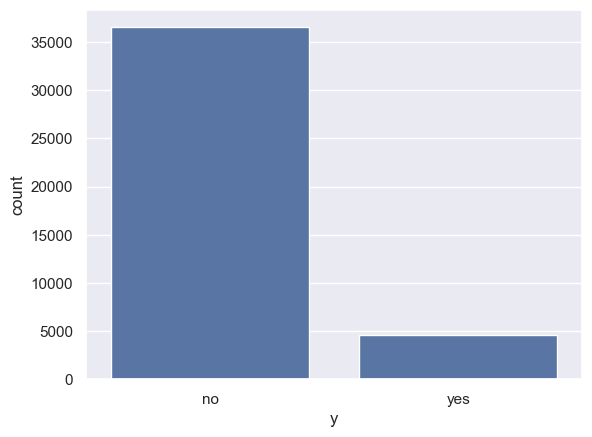

In [26]:
sns.countplot(x='y', data=df) 
plt.show()

La modalité 'yes' représentant 11%, ce chiffre est suffisamment elevé pour écarter l'hypohtèse de sous-representation de cette dernière.

**Variables Catégorielles**

Pour les variables catégorielles nous affichons un stacked plot en fonction de **y**. Nous calculons également la valeur de la p-value issue d'un test de Khi-carré en complément du graphique.

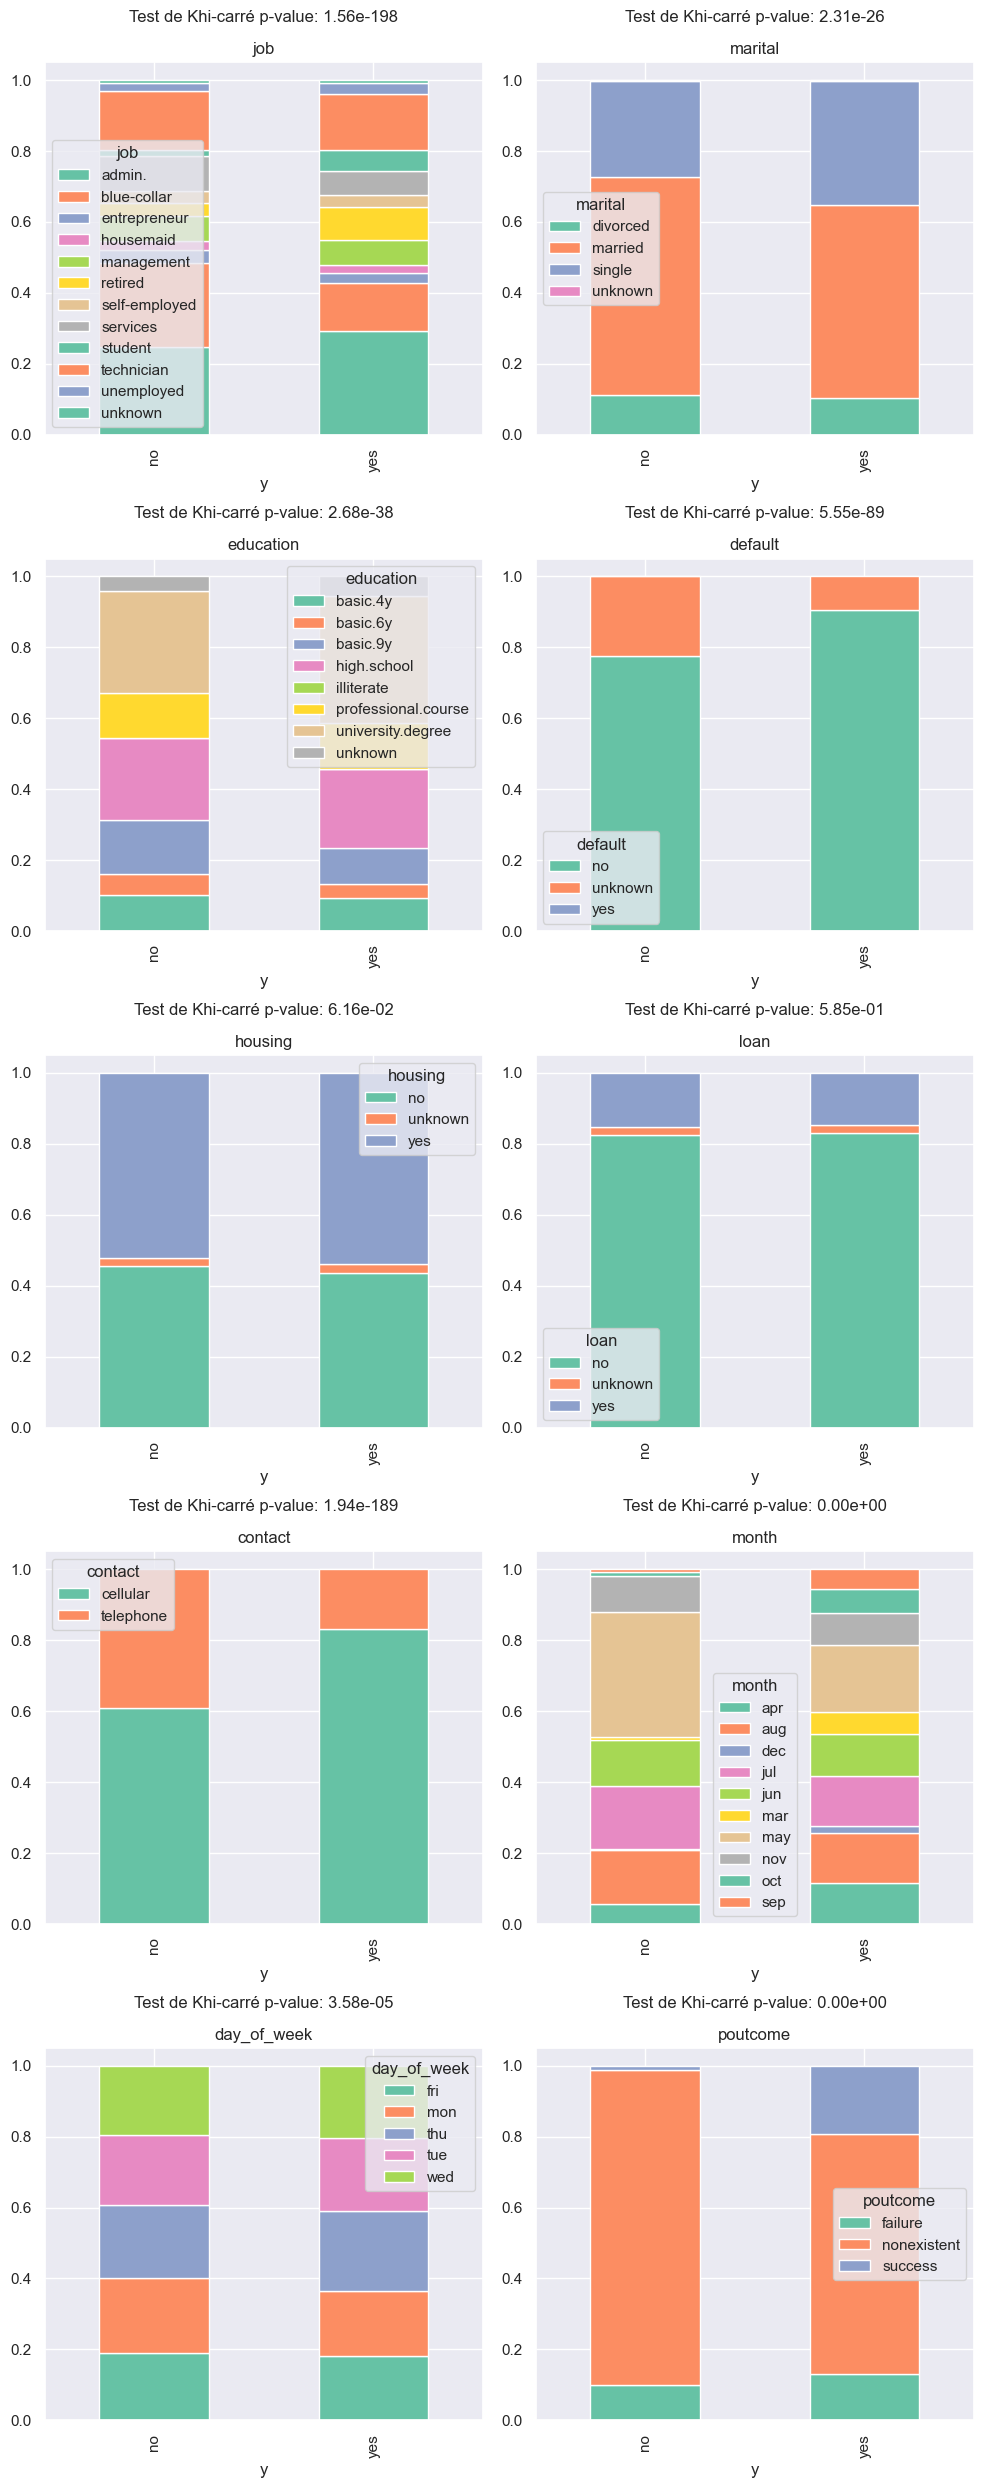

In [27]:
n_cols = 2
n_rows = math.ceil(len(var_cat[:-1]) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))

for i, c in enumerate(var_cat[:-1]):
    row = i // n_cols
    col = i % n_cols

    contingency_table = pd.crosstab(df['y'], df[c])
    chi2, p, _, _ = chi2_contingency(contingency_table)

    df.groupby('y')[c].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=axes[row, col], color= palette)

    axes[row, col].set_title(c)
    axes[row, col].text(0.5, 1.1, f'Test de Khi-carré p-value: {p:.2e}', ha='center', va='bottom', transform=axes[row, col].transAxes)
    

# Supprimer les axes inutilisés si le nombre de colonnes est impair
if len(var_cat[:-1]) % n_cols != 0:
    for j in range(len(var_cat[:-1]), n_rows * n_cols):
        fig.delaxes(axes.flat[j])

plt.tight_layout()
plt.show()

Nous voyons visuellement et au moyen de la p-value (>0.05) que les variables **housing** et **loan**  ont un impact faible sur la target variable. Nous décidons de les retirer du dataframe et conservons le reste des features. 

**Variables Numériques**

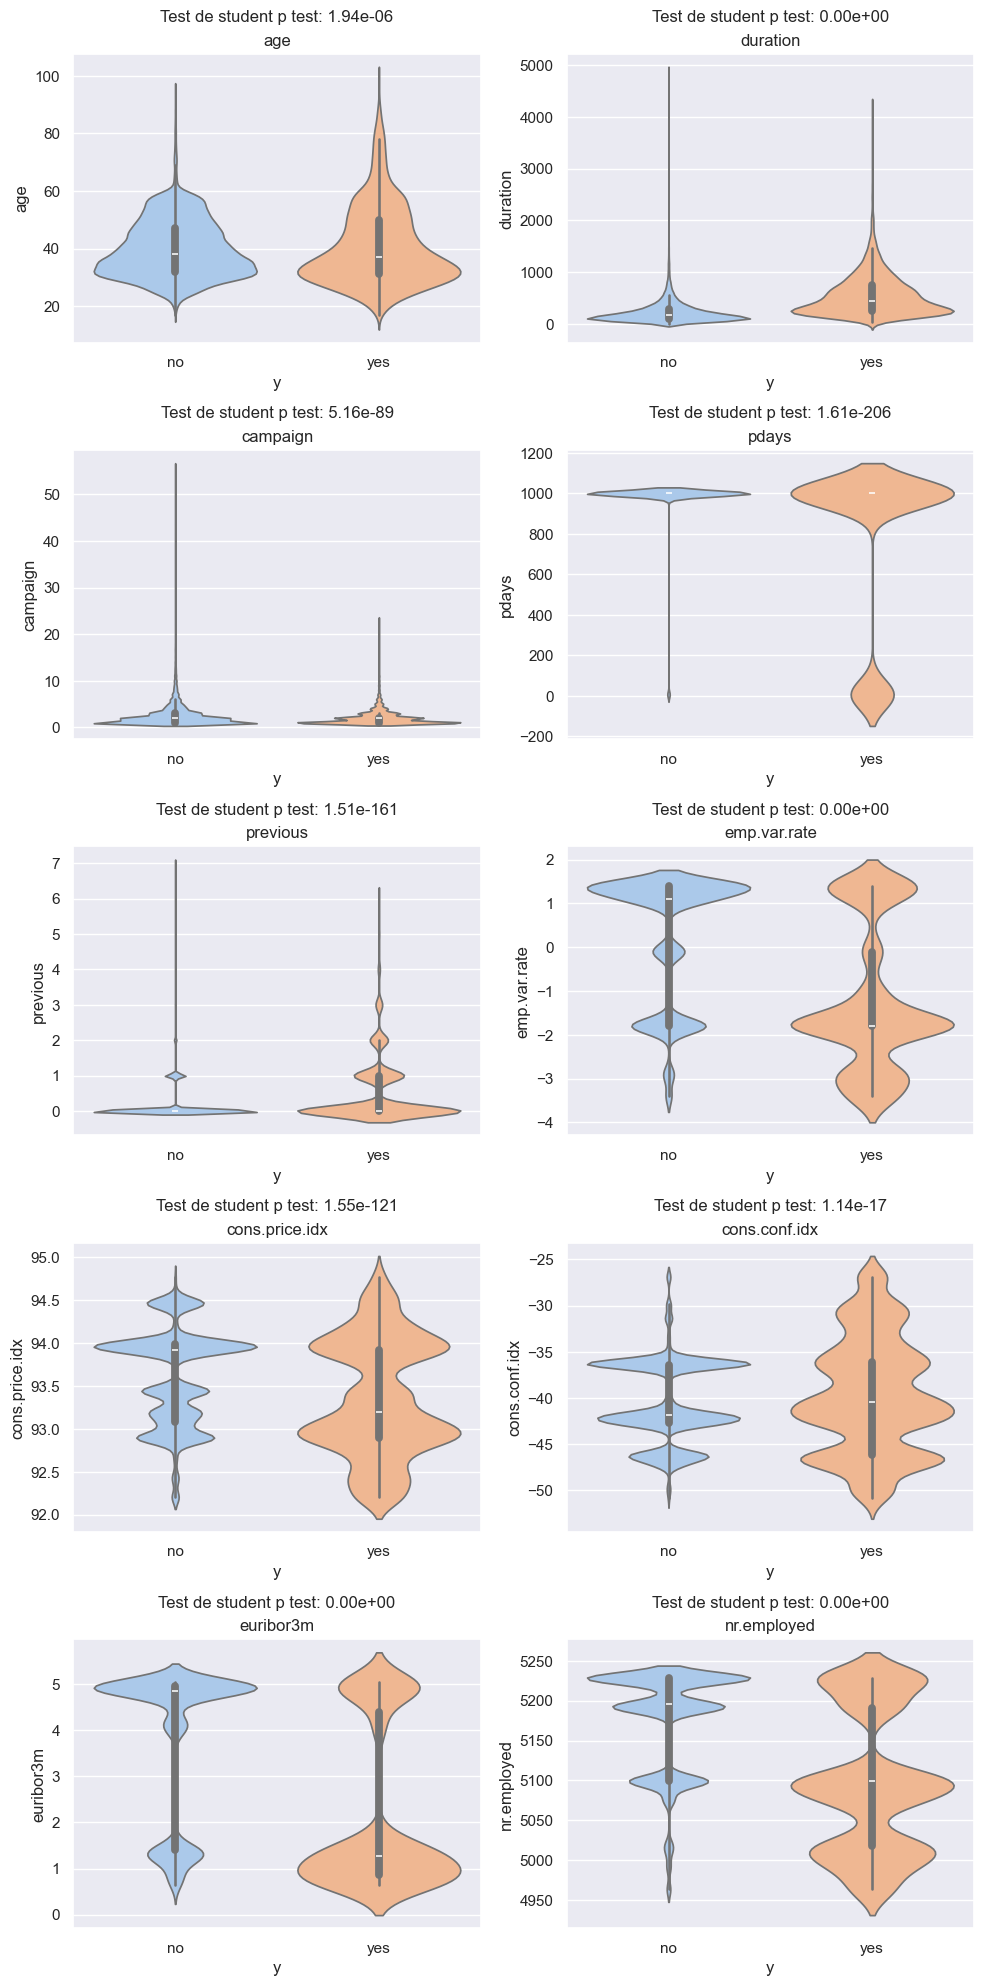

In [28]:
n_cols = 2
n_rows = math.ceil(len(cols_numeriques) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))

for i, c in enumerate(cols_numeriques):
    row = i // n_cols
    col = i % n_cols

    U1, p = ttest_ind(df.query('y =="yes"')[c], df.query('y =="no"')[c], equal_var=False)

    sns.violinplot(data=df, x='y', y=c, ax=axes[row, col], hue='y', palette="pastel", legend=False)
    axes[row, col].set_title(c)
    axes[row, col].text(0.5, 1.1, f'Test de student p test: {p:.2e}', ha='center', va='bottom', transform=axes[row, col].transAxes)

# Supprimer les axes inutilisés si le nombre de colonnes est impair
if len(cols_numeriques) % n_cols != 0:
    for j in range(len(cols_numeriques), n_rows * n_cols):
        fig.delaxes(axes.flat[j])

plt.tight_layout()
plt.show()

Parmi les variables numériques toutes semblent signifcatives. 

In [29]:
## Drop des variables housing et loan

df_clean = df.drop('housing', axis=1)
df_clean = df_clean.drop('loan', axis=1)

### 1.5 Analyse des corrélations

**Corrélation des variables numériques**

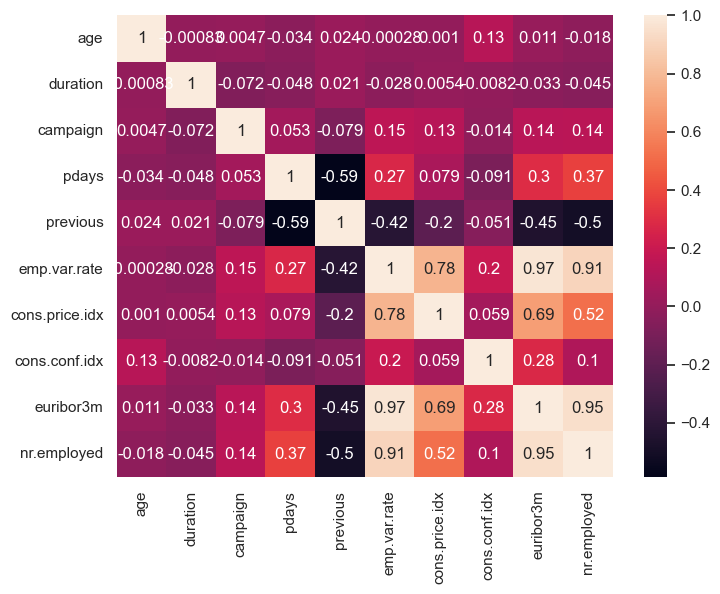

In [30]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[cols_numeriques].corr(), annot=True)
plt.show()

Nous observons des fortes corrélations entre plusieurs variables. Nous décidons de drop les plus corrélées, à savoir **euribor3m** et **emp.var.rate**

In [31]:
df_clean = df_clean.drop('euribor3m', axis=1)
df_clean = df_clean.drop('emp.var.rate', axis=1)

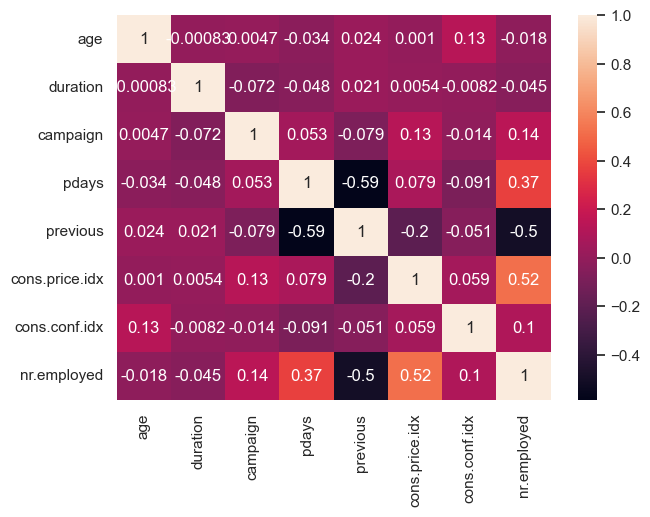

In [32]:
new_col_nums = [x for x in cols_numeriques if x not in ['euribor3m', 'emp.var.rate']]

plt.figure(figsize=(7, 5))
sns.heatmap(df[new_col_nums].corr(), annot=True)
plt.show()

**Corrélation des variables via le V de Cramer**

De la même manière que nous avons calculé la corrélation entre variables numérique via le coefficient de Pearson, il est possible de quantifier la relation via le V de Cramer.

Ce dernier présente l’avantage d’être plus lisible que la probabilité associée au Khi-deux, et de fournir une mesure absolue de l’intensité de la liaison entre deux variables qualitatives ou quantitatives discrètes, indépendamment du nombre de leurs modalités et de l’effectif de la population.

In [33]:
def cramers_corrected_stat(x,y):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    result=-1
    if len(x.value_counts())==1 :
        print("First variable is constant")
    elif len(y.value_counts())==1:
        print("Second variable is constant")
    else:
        conf_matrix=pd.crosstab(x, y)

        if conf_matrix.shape[0]==2:
            correct=False
        else:
            correct=True

        chi2 = chi2_contingency(conf_matrix, correction=correct)[0]

        n = sum(conf_matrix.sum())
        phi2 = chi2/n
        r,k = conf_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        result=np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
    return round(result,6)

In [34]:
df_clean_corr = df_clean.drop(['cons.price.idx', 'cons.conf.idx'], axis=1)

n_cols = df_clean_corr.shape[1]
cramers_matrix = np.zeros((n_cols, n_cols))

for i in range(n_cols):
    for j in range(i, n_cols):
        v_cramer = cramers_corrected_stat(df_clean_corr.iloc[:, i], df_clean_corr.iloc[:, j])
        cramers_matrix[i, j] = v_cramer
        cramers_matrix[j, i] = v_cramer

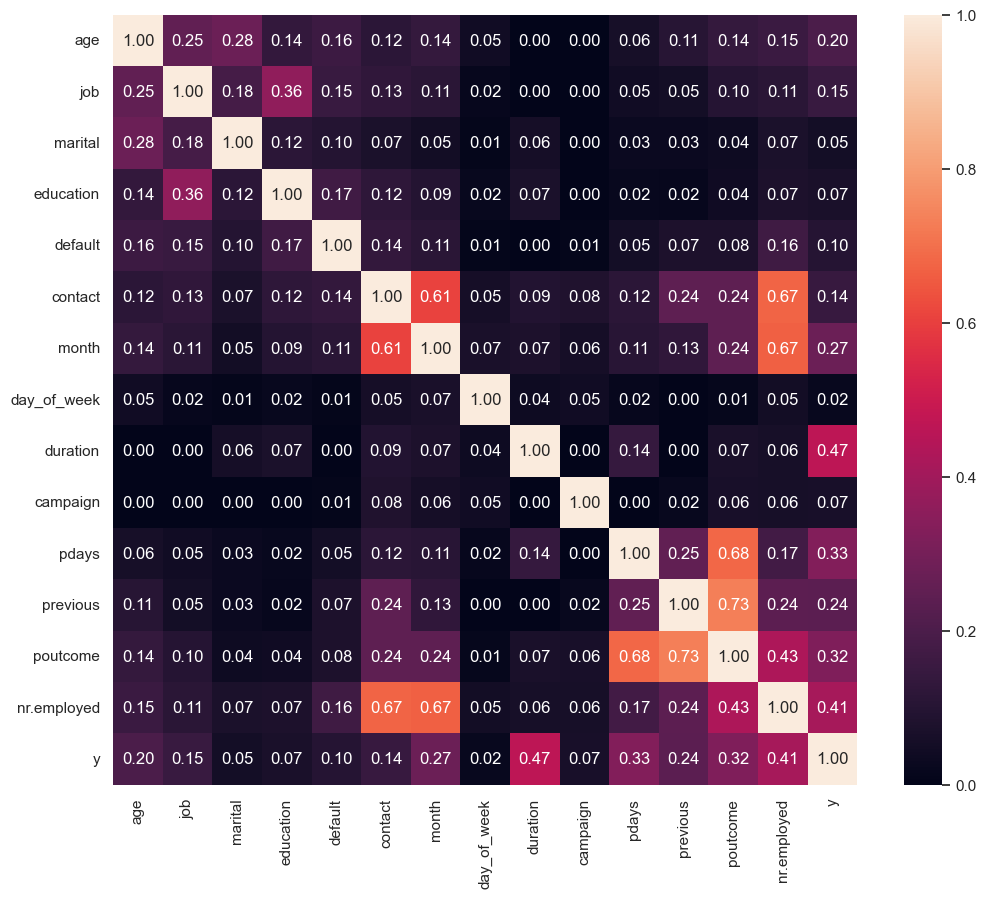

In [35]:
plt.figure(figsize=(12, 10))
sns.heatmap(cramers_matrix, annot=True, fmt=".2f",
            xticklabels=df_clean_corr.columns, yticklabels=df_clean_corr.columns)
plt.show()

L'ensemble des valeurs issues du V de cramer étant strictement **inférieur à 0.8**, nous conservons donc les variables.


## 2. Préparation jeu de données

### 2.1 Split train et test set

In [36]:
X = df_clean.drop('y', axis=1)
y = df_clean['y'].map({'yes': 1, 'no': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2.2 Pipeline encoding + scaling

In [37]:
var_cat_final = df_clean.select_dtypes(include=['object']).columns.tolist()[:-1]
var_num_final = df_clean.select_dtypes(exclude=['object']).columns.tolist()


categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = MinMaxScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, var_num_final),
        ('cat', categorical_transformer, var_cat_final)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

X_train_prepared = pipeline.fit_transform(X_train).toarray()
X_test_prepared = pipeline.transform(X_test).toarray()

print(X_train_prepared.shape)
print(X_test_prepared.shape)

(32937, 55)
(8235, 55)


In [38]:
# Check des proportion du split
print(y_train.value_counts(normalize=True)[0])
print(y_test.value_counts(normalize=True)[0])
print(y.value_counts(normalize=True)[0])

0.8876946898624647
0.8859744990892532
0.8873506266394637


## 3. Modélisation

Pour la partie modélisation nous utiliserons plusieurs algorithmes de classification : 
- Régression logistique
- Random forest
- Xgboost
- Catboost
- ANN

Nous implémentons dans un premier temps les différents algorithmes avec leurs paramètres initiaux puis tunons les hyperparamètres au moyen de l'approche bayésienne via la librairie Optuna


### 3.1 Modèles initiaux

In [39]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(), 
    'Xgboost': XGBClassifier(), 
    'Catboost': CatBoostClassifier()
}

for name, model in models.items():
    if name == 'Catboost': 
        model.fit(X_train_prepared, y_train, plot = False, logging_level='Silent')
    else : 
        model.fit(X_train_prepared, y_train)

    y_pred = model.predict(X_test_prepared)
    
    cm = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"---------------------{name} Metrics: ---------------------")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print('Confusion matrix :\n', cm)

---------------------Logistic Regression Metrics: ---------------------
Precision: 0.6847
Recall: 0.4047
F1-Score: 0.5087
Confusion matrix :
 [[7121  175]
 [ 559  380]]
---------------------Random Forest Metrics: ---------------------
Precision: 0.6652
Recall: 0.4952
F1-Score: 0.5678
Confusion matrix :
 [[7062  234]
 [ 474  465]]
---------------------Xgboost Metrics: ---------------------
Precision: 0.6457
Recall: 0.5240
F1-Score: 0.5785
Confusion matrix :
 [[7026  270]
 [ 447  492]]
---------------------Catboost Metrics: ---------------------
Precision: 0.6844
Recall: 0.5474
F1-Score: 0.6083
Confusion matrix :
 [[7059  237]
 [ 425  514]]


### 3.1 Modèles tunés

**Regression Logistique**

In [259]:
number_trials = 100

In [260]:
# Tuning regression logistique
def tune_logistic(trial:optuna.Trial):

    param = {
        'penalty': trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet", None]),
        'C' : trial.suggest_float('C', 1e-6, 1e3, log = True), 
        'max_iter' : trial.suggest_int('max_iter', 100, 1e4, log = True)
    }

    if param['penalty'] == 'elasticnet': 
        param['l1_ratio'] = trial.suggest_float('l1_ratio', 1e-6, 1, log= True)
        param['solver'] = 'saga'

    if param['penalty'] == 'l1':
        param['solver'] = trial.suggest_categorical('solver_l1', ['liblinear','saga'])

    if param['penalty'] == 'l2':
        param['solver'] = trial.suggest_categorical('solver_l2', ['lbfgs','newton-cg','liblinear','saga', 'sag'])

    
    logistic = LogisticRegression(**param)

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
    score = cross_val_score(logistic, X_train_prepared, y_train, scoring='f1', cv=kfold).mean()
    
    return score

In [261]:
sampler = TPESampler(seed=21)
study_lr = optuna.create_study(direction='maximize', sampler = sampler)
study_lr.optimize(tune_logistic, n_trials = number_trials)

[I 2024-05-31 07:33:15,773] A new study created in memory with name: no-name-632516a0-5cfb-4718-8757-5687966059a7
[I 2024-05-31 07:33:17,442] Trial 0 finished with value: 0.0 and parameters: {'penalty': 'elasticnet', 'C': 7.133536494718945e-05, 'max_iter': 126, 'l1_ratio': 6.51075515971989e-05}. Best is trial 0 with value: 0.0.
[I 2024-05-31 07:33:21,162] Trial 1 finished with value: 0.5077047316463643 and parameters: {'penalty': 'l1', 'C': 64.06788036451141, 'max_iter': 184, 'solver_l1': 'saga'}. Best is trial 1 with value: 0.5077047316463643.
[I 2024-05-31 07:33:22,766] Trial 2 finished with value: 0.15818855760391748 and parameters: {'penalty': 'elasticnet', 'C': 0.0028724355221069154, 'max_iter': 655, 'l1_ratio': 0.01906174113168418}. Best is trial 1 with value: 0.5077047316463643.
[I 2024-05-31 07:33:24,334] Trial 3 finished with value: 0.3517718497462839 and parameters: {'penalty': 'elasticnet', 'C': 0.04467009126986524, 'max_iter': 216, 'l1_ratio': 6.196604094564109e-05}. Best i

**Random Forest**

In [262]:
def tune_rf(trial):

    param = {
        'n_estimators' : trial.suggest_int("n_estimators", 10, 400, log=True),
        'max_depth' : trial.suggest_int("max_depth", 2, 64),
        'min_samples_split' : trial.suggest_int("min_samples_split", 2, 10),
        'min_samples_leaf' : trial.suggest_int("min_samples_leaf", 1, 10)
    }

    rf = RandomForestClassifier(**param)

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
    score = cross_val_score(rf, X_train_prepared, y_train, scoring='f1', cv=kfold).mean()
    
    return score

In [263]:
sampler = TPESampler(seed=21)
study_rf = optuna.create_study(direction='maximize', sampler = sampler)
study_rf.optimize(tune_rf, n_trials = number_trials)

[I 2024-05-31 07:34:42,346] A new study created in memory with name: no-name-79baf9bf-f7b3-4201-a22e-4ae1954d00c3
[I 2024-05-31 07:34:43,399] Trial 0 finished with value: 0.5197520042305315 and parameters: {'n_estimators': 11, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.5197520042305315.
[I 2024-05-31 07:34:44,319] Trial 1 finished with value: 0.27879793274560694 and parameters: {'n_estimators': 21, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.5197520042305315.
[I 2024-05-31 07:34:46,828] Trial 2 finished with value: 0.49212347544574336 and parameters: {'n_estimators': 30, 'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.5197520042305315.
[I 2024-05-31 07:34:48,046] Trial 3 finished with value: 0.4404682506463386 and parameters: {'n_estimators': 16, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 0 with value: 0

**XgBoost**

In [264]:
def tune_xgb(trial):
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "tree_method": "exact",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    xgb = XGBClassifier(**param)

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
    score = cross_val_score(xgb, X_train_prepared, y_train, scoring='f1', cv=kfold).mean()

    return score

In [265]:
sampler = TPESampler(seed=21)
study_xgb = optuna.create_study(direction='maximize', sampler = sampler)
study_xgb.optimize(tune_xgb, n_trials = number_trials)

[I 2024-05-31 08:04:11,271] A new study created in memory with name: no-name-12e3c1ef-868a-4e49-ac20-e277069a5aed
[I 2024-05-31 08:04:19,839] Trial 0 finished with value: 0.0 and parameters: {'booster': 'dart', 'lambda': 1.4891210381075092e-08, 'alpha': 4.439991330753759e-07, 'subsample': 0.24061860535630145, 'colsample_bytree': 0.4418175151716935, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.0004663695745275388, 'gamma': 3.602198465642853e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.5806053091762127, 'skip_drop': 0.011869171969835073}. Best is trial 0 with value: 0.0.
[I 2024-05-31 08:04:33,045] Trial 1 finished with value: 0.0 and parameters: {'booster': 'dart', 'lambda': 1.4633835924425082e-06, 'alpha': 0.06804919248114097, 'subsample': 0.9305311756894445, 'colsample_bytree': 0.808604855731685, 'max_depth': 7, 'min_child_weight': 3, 'eta': 2.452100878199486e-06, 'gamma': 1.8687205446770345e-06, 'grow_policy': 'lossguide', 's

**CatBoost**

In [266]:
def tune_catboost(trial: optuna.Trial) -> float:
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        "eval_metric": "Accuracy",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    gbm = CatBoostClassifier(**param, logging_level='Silent')

    kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=21)
    score = cross_val_score(gbm, X_train_prepared, y_train, scoring='f1', cv=kfold).mean()
    
    return score

In [267]:
sampler = TPESampler(seed=21)
study_catboost = optuna.create_study(direction='maximize', sampler = sampler)
study_catboost.optimize(tune_catboost, n_trials = 50)

[I 2024-05-31 08:14:19,199] A new study created in memory with name: no-name-170bc8c2-434d-448b-82b5-9921293e5611
[I 2024-05-31 08:15:45,548] Trial 0 finished with value: 0.36954010302386553 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.05259765072681896, 'depth': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3833463003091129}. Best is trial 0 with value: 0.36954010302386553.
[I 2024-05-31 08:16:08,469] Trial 1 finished with value: 0.31813709923474 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.013590659107103026, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.24224232832813447}. Best is trial 0 with value: 0.36954010302386553.
[I 2024-05-31 08:17:37,539] Trial 2 finished with value: 0.36447007867055603 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.018649610789480263, 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_tempe

**ANN**

In [268]:
# Function to create model
def nn_cl_bo2(neurons, activation, optimizer, learning_rate, batch_size, epochs,
              layers1, layers2, normalization, dropout, dropout_rate, get_model = False):
    optimizerL = ['SGD',
                  'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl']
    optimizerD= {'Adam':Adam(learning_rate=learning_rate), 'SGD':SGD(learning_rate=learning_rate),
                 'RMSprop':RMSprop(learning_rate=learning_rate), 'Adadelta':Adadelta(learning_rate=learning_rate),
                 'Adagrad':Adagrad(learning_rate=learning_rate), 'Adamax':Adamax(learning_rate=learning_rate),
                 'Nadam':Nadam(learning_rate=learning_rate), 'Ftrl':Ftrl(learning_rate=learning_rate)}
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu','relu']

    activation = activationL[activation]
    optimizer = optimizerD[optimizerL[optimizer]]

    def nn_cl_fun():
        nn = Sequential()
        nn.add(Dense(units=neurons, activation=activation,  input_shape=(X_train_prepared.shape[1],)))
        if normalization:
            nn.add(BatchNormalization())
        for i in range(layers1):
             nn.add(Dense(units=neurons, activation=activation))
        if dropout:
            nn.add(Dropout(dropout_rate))
        for i in range(layers2):
            nn.add(Dense(units=neurons, activation=activation))
        if dropout:
            nn.add(Dropout(dropout_rate))

        nn.add(Dense(units =1, activation = 'sigmoid'))
        nn.compile(optimizer=optimizer, loss='binary_crossentropy')
        return nn

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=round(epochs/4))
    nn = KerasClassifier(nn_cl_fun(), epochs=epochs, batch_size=batch_size, validation_split=0.2, metrics= ['f1_score'], verbose = 0)
    if get_model:
        return nn
    
    kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=21)
    score = cross_val_score(nn, X_train_prepared, y_train, scoring='f1', cv=kfold).mean()

    return score


In [269]:
def tune_ann(trial:optuna.Trial):
  # list des hyperparmaètres
    neurons = trial.suggest_int('neurons', 4, 32)
    activation = trial.suggest_int('activation', 0, 7)
    optimizer = trial.suggest_int('optimizer', 0, 7)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1, log = True)
    batch_size = trial.suggest_int('batch_size', 1, 50, log = True)
    epochs = trial.suggest_int('epochs', 10, 100)
    layers1 = trial.suggest_int('layers1', 1, 2)
    layers2 = trial.suggest_int('layers2', 0, 2)
    normalization = trial.suggest_categorical('normalization', [True, False]),
    dropout = trial.suggest_categorical('dropout', [True, False]),
    dropout_rate = trial.suggest_float('dropout_rate', 0, 0.3)

    return nn_cl_bo2(neurons=neurons, activation=activation, optimizer=optimizer, learning_rate=learning_rate,
              batch_size=batch_size, epochs=epochs,  layers1=layers1, layers2=layers2,
              normalization=normalization, dropout=dropout, dropout_rate=dropout_rate
              )

In [270]:
sampler = TPESampler(seed=21)
study_ann = optuna.create_study(direction='maximize', sampler = sampler)
study_ann.optimize(tune_ann, n_trials = 50)

[I 2024-05-31 09:16:09,462] A new study created in memory with name: no-name-11bf16f8-d1c0-4065-887a-12a3a2149df1
[I 2024-05-31 09:21:02,365] Trial 0 finished with value: 0.0 and parameters: {'neurons': 5, 'activation': 2, 'optimizer': 5, 'learning_rate': 0.0011610441905361485, 'batch_size': 1, 'epochs': 14, 'layers1': 1, 'layers2': 1, 'normalization': False, 'dropout': False, 'dropout_rate': 0.03997215577552432}. Best is trial 0 with value: 0.0.
[I 2024-05-31 09:21:52,723] Trial 1 finished with value: 0.281031199675184 and parameters: {'neurons': 9, 'activation': 3, 'optimizer': 6, 'learning_rate': 0.1891609587474209, 'batch_size': 44, 'epochs': 79, 'layers1': 1, 'layers2': 1, 'normalization': True, 'dropout': False, 'dropout_rate': 0.22822682089938184}. Best is trial 1 with value: 0.281031199675184.
[I 2024-05-31 09:30:40,936] Trial 2 finished with value: 0.48448314507456 and parameters: {'neurons': 18, 'activation': 1, 'optimizer': 2, 'learning_rate': 0.007109337552527563, 'batch_si

## 4. Résultats

### 4.1 Comparaison des modèles

In [271]:
# Si solver_l1 ou solver_l2 remettre solver comme key
best_param_lr = {k if not k.startswith('solver_') else 'solver': v for k, v in study_lr.best_params.items()}

best_model = {
    'best_lr': LogisticRegression(**best_param_lr),
    'best_rf': RandomForestClassifier(**study_rf.best_params), 
    'best_xgb': XGBClassifier(**study_xgb.best_params), 
    'best_catboost': CatBoostClassifier(**study_catboost.best_params),
    'best_ann':  nn_cl_bo2(**study_ann.best_params, get_model=True)
    }

In [272]:
metrics = ['recall', 'precision', 'f1', 'accuracy', 'auc_score']
results = {}

for name, model in best_model.items():

    if name == 'best_catboost': 
        model.fit(X_train_prepared, y_train, plot = False, logging_level='Silent')
    else : 
        model.fit(X_train_prepared, y_train)
    
    y_pred = model.predict(X_test_prepared)
    y_pred_proba = model.predict_proba(X_test_prepared)[:, 1]

    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    results[name] = {
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'accuracy': accuracy,
        'auc_score': auc_score
    }

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.columns = metrics

df_results

,recall,precision,f1,accuracy,auc_score
best_lr,0.421725,0.678082,0.520026,0.911233,0.934354
best_rf,0.489883,0.677467,0.568603,0.915240,0.944159
best_xgb,0.560170,0.676963,0.613054,0.919369,0.949215
best_catboost,0.537806,0.695592,0.606607,0.920461,0.949933
best_ann,0.534611,0.632242,0.579342,0.911475,0.938765


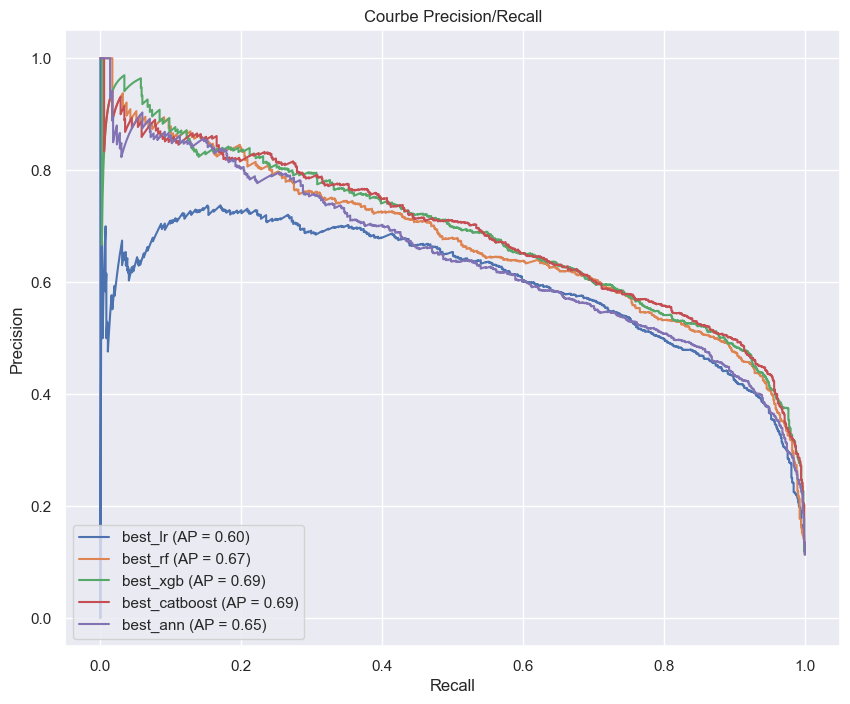

In [273]:
model_names = list(best_model.keys())
plt.figure(figsize=(10, 8))

for i, (name, model) in enumerate(best_model.items()):
    y_pred_proba = model.predict_proba(X_test_prepared)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall, precision, label=f'{name} (AP = {average_precision_score(y_test, y_pred_proba):.2f})')

plt.legend(loc='lower left')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbe Precision/Recall')

plt.show()

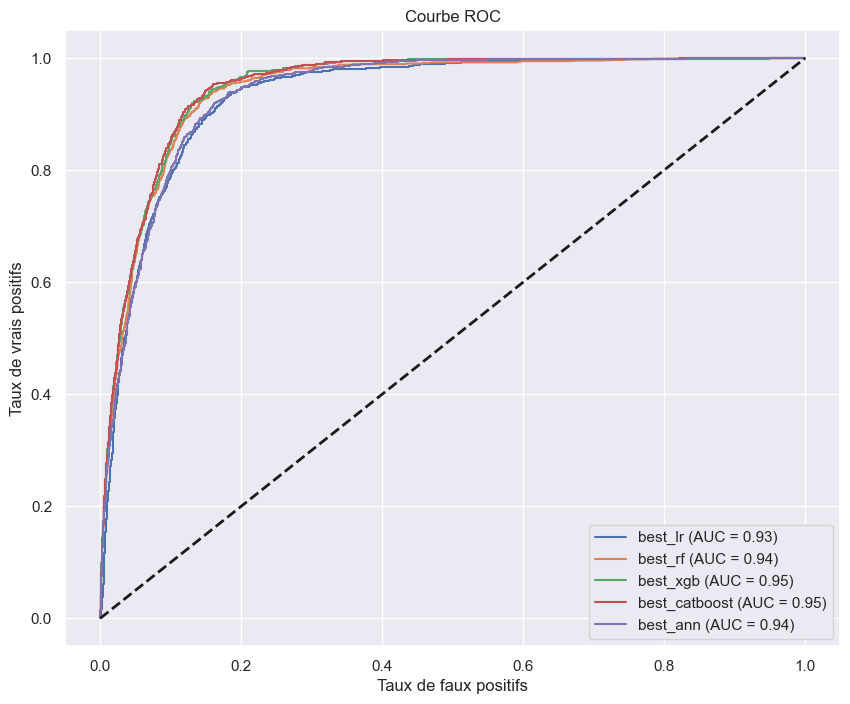

In [274]:
model_names = list(best_model.keys())
plt.figure(figsize=(10, 8))

for i, (name, model) in enumerate(best_model.items()):
    
    y_pred_proba = model.predict_proba(X_test_prepared)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')


plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.legend(loc='lower right')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.show()

### 4.2 Feature importance

Nous décidons également de regarder la feature importance de notre meilleur modèle. Pour
cela nous utilisons la méthode des permutations implémentée par Sklearn.
Cette méthode consiste à mesurer la diminution de la performance d'un modèle lorsqu'on
permute de manière aléatoire les valeurs d'une caractéristique particulière, ce qui permet de
quantifier l'impact de cette caractéristique sur les prédictions du modèle. Plus la performance
du modèle diminue après permutation, plus la caractéristique est jugée importante

In [275]:
from sklearn.inspection import permutation_importance

num_cols = var_num_final
cat_cols = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(var_cat_final)
all_cols = num_cols + list(cat_cols)

result = permutation_importance(
    best_model['best_rf'], X_test_prepared, y_test, n_repeats=10, random_state=42, n_jobs=2
)


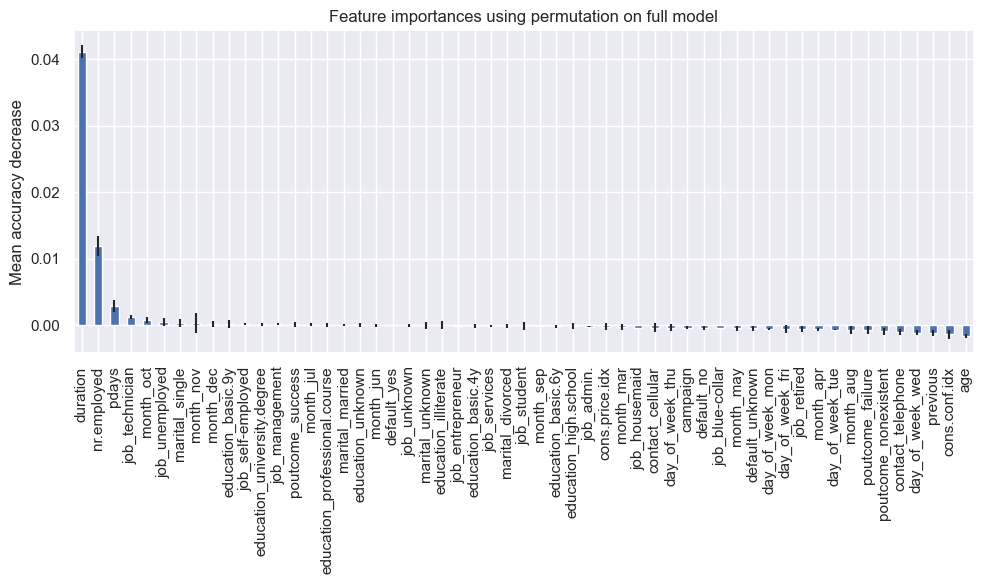

In [276]:
features_importances = pd.Series(result.importances_mean, index=all_cols).sort_values(ascending=False)


fig, ax = plt.subplots(figsize=(10, 6))
features_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Nous voyons dès lors que sur les 55 variables, beaucoup ne sont que peu significatives.
Également que la variable duration a une part importante dans l’explicabilité.

### 4.3 Calibration des modèles

Dans cette dernière partie, nous analysons la calibration du modèle. La sortie des modèles étant des scores de probabilités on attendrait d'un modèle parfaitement calibré que lorsque ce dernier prédit une probabilité de 90%,
la proportion observée soit effectivement de 90% ; et ce pour tout pourcentage.

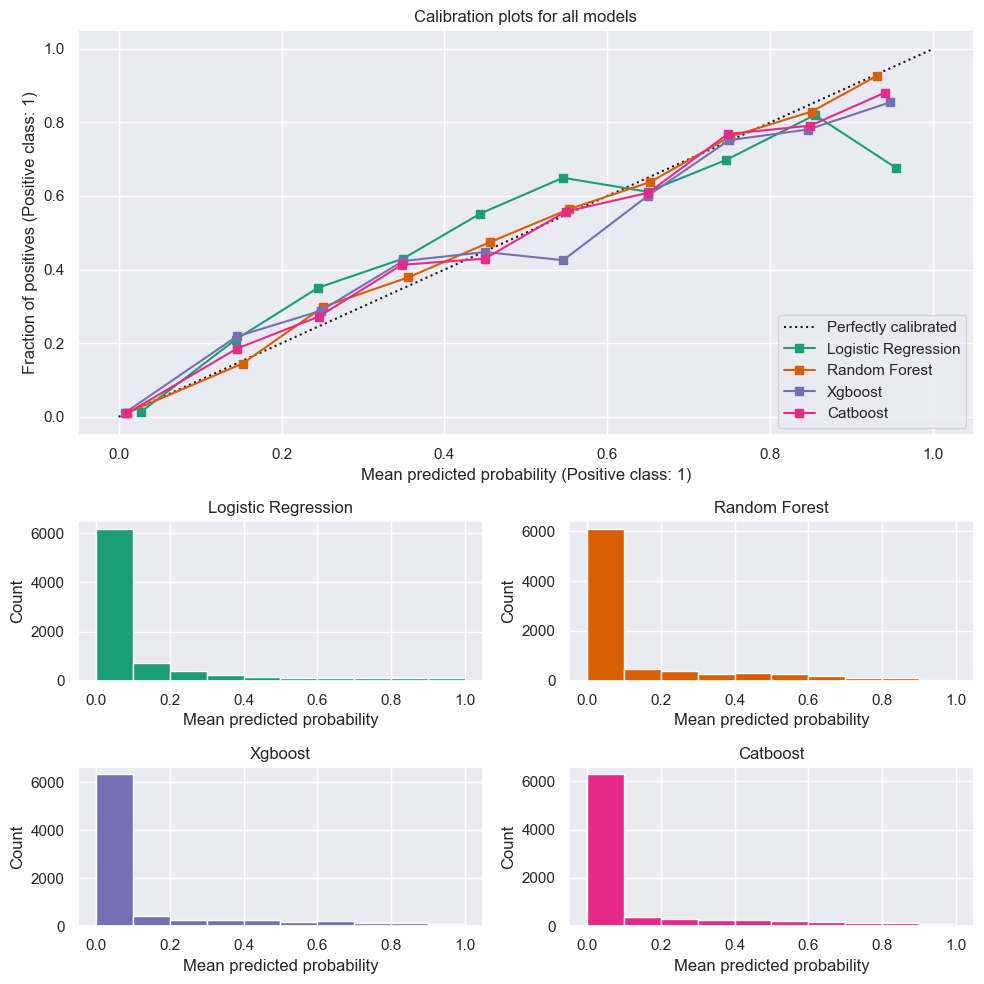

In [43]:
from sklearn.calibration import CalibrationDisplay

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

for i, (name, model) in enumerate(models.items()):
    if name == 'Catboost': 
        model.fit(X_train_prepared, y_train, plot=False, logging_level='Silent')
    else:
        model.fit(X_train_prepared, y_train)
    
    display = CalibrationDisplay.from_estimator(
        model,
        X_test_prepared,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.set_title("Calibration plots for all models")

grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (name, _) in enumerate(models.items()):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

L'ensemble des modèles sont relativement bien calibrés avec Catboost comme modèle ayant la meilleure calibration. 